# Visualize context diversity with examples
In which we visualize frequency vs. context diversity and include example words.

In [82]:
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import sys
if('..' not in sys.path):
    sys.path.append('..')
from data_processing.data_handler import melt_frames, smooth_stats, get_binned_stats
from prediction.prediction_helpers import match_words
from data_processing.vis_helper import plot_separate_stats

## Load data

In [85]:
tf = pd.read_csv('../../data/frequency/2013_2016_tf.tsv', sep='\t', index_col=0)
C2 = pd.read_csv('../../data/frequency/2013_2016_2gram_1pos_residuals.tsv', sep='\t', index_col=0)
C3 = pd.read_csv('../../data/frequency/2013_2016_3gram_1pos_residuals.tsv', sep='\t', index_col=0)
all_stats = [tf, C2, C3]
vocab = reduce(lambda x,y: x&y, [s.index for s in all_stats])
print(len(vocab))
all_stats = [s.loc[vocab] for s in all_stats]
# smooth tf
all_stats[0] = pd.np.log10(smooth_stats(all_stats[0].fillna(0, inplace=False)))
tf_smooth = all_stats[0]
stat_names = ['f', 'C2', 'C3']
print('bout to combine stats')
combined_df = melt_frames(all_stats, stat_names)
print(combined_df.head())

99998
bout to combine stats
      word     date         f        C2        C3
0       aa  2013-06  4.168497  0.123702  0.148911
1      aaa  2013-06  3.961326  0.041110  0.062186
2     aaaa  2013-06  2.021189 -0.138646 -0.196020
3    aaaah  2013-06  2.745855 -0.393687 -0.497060
4  aaaahhh  2013-06  2.330414 -0.462309 -0.471153


In [87]:
pd.set_option('display.max_rows', 100)
initial_date = '2014-06'
growth_words = pd.read_csv('../../data/frequency/word_lists/2013_2016_growth_words_clean.csv', index_col=False)['word'].tolist()
growth_df = combined_df[(combined_df['word'].isin(growth_words)) & (combined_df['date'] == initial_date)]
print(growth_df.sort_values('C2', inplace=False, ascending=True))
print(growth_df.sort_values('C3', inplace=False, ascending=True))
print('growth C2 mean %.3f'%(growth_df['C2'].mean()))
print('growth C3 mean %.3f'%(growth_df['C3'].mean()))

                         word     date         f        C2        C3
1299077                 yikes  2014-06  3.766785 -0.685396 -0.970771
1236120                gotcha  2014-06  4.089057 -0.616804 -0.766878
1251084                 looot  2014-06  2.787460 -0.585907 -0.683610
1264466                 peasy  2014-06  2.886491 -0.540321 -0.608310
1296658                  welp  2014-06  4.011570 -0.482177 -0.688822
1240489                hoooly  2014-06  2.726727 -0.480598 -0.457675
1255632                  mins  2014-06  4.350461 -0.464961 -0.615849
1258230                   nah  2014-06  4.813634 -0.461690 -0.731196
1275655                saaame  2014-06  2.025306 -0.442518 -0.365881
1242028                   ikr  2014-06  3.341830 -0.438920 -0.545364
1290903                 truuu  2014-06  2.164353 -0.432694 -0.443716
1298928                  yeah  2014-06  5.936042 -0.430858 -0.770347
1266696                  pmed  2014-06  3.149835 -0.413968 -0.397313
1250927                  lolk  201

## Gather lower, median, upper values

In [88]:
y_stat_vars = ['C2', 'C3']
x_stat_var = 'f'
x_stat = combined_df[x_stat_var]
x_bin_width = 0.25
lower_percentile = 10
upper_percentile = 90
stat_vals = {}
for y_stat_var in y_stat_vars:
    y_stat = combined_df[y_stat_var]
    x_vals, lower_percentile_vals, median_vals, upper_percentile_vals = get_binned_stats(x_stat, y_stat, 
                                                                                         x_bin_width=x_bin_width, 
                                                                                         lower_percentile=lower_percentile,
                                                                                         upper_percentile=upper_percentile)
    stat_vals[y_stat_var] = (x_vals, lower_percentile_vals, median_vals, upper_percentile_vals)

## Static plot
Just plot growth words and their frequency/C value at the first timestep.

$C^{2}$
$C^{3}$


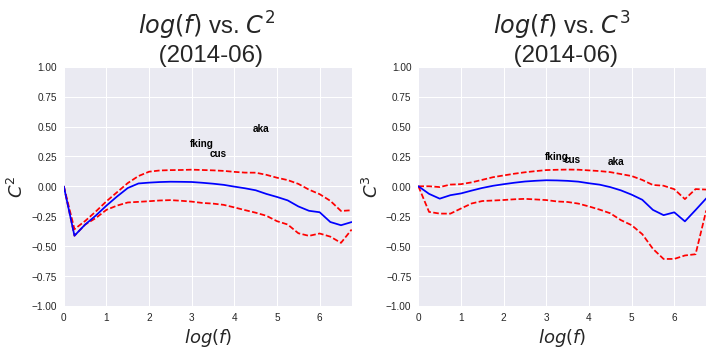

In [91]:
y_stat_names = ['$C^{2}$', '$C^{3}$']
x_stat_name = '$log(f)$'
annotate_words = ['aka', 'cus', 'fking']
# avoid: idgaf, flaired, af, clunky, clunkiness, fuckboy
initial_date = '2014-06'
size = 5
rows = 1
cols = len(y_stat_names)
y_lower = -1.0
y_upper = 1.0
txt_offset_x = 0.
txt_offset_y = 0.
plt.figure(figsize=(cols*size, rows*size))
# x_lower = 1.75
# x_upper = 5
for i, (y_var, y_name) in enumerate(zip(y_stat_vars, y_stat_names)):
    print(y_name)
    plt.subplot(rows, cols, i+1)
    # plot percentiles first
    x_vals, lower_percentile_vals, median_vals, upper_percentile_vals = stat_vals[y_var]
    plt.plot(x_vals, lower_percentile_vals, 'r--')
    plt.plot(x_vals, upper_percentile_vals, 'r--')
    # plot medians differently
    plt.plot(x_vals, median_vals, 'b-')
    plt.title('%s vs. %s \n (%s)'%(x_stat_name, y_name, initial_date), fontsize=24)
    plt.xlabel(x_stat_name, fontsize=18)
    plt.ylabel(y_name, fontsize=18)
    x_lower = min(x_vals)
    x_upper = max(x_vals)
    plt.xlim(x_lower, x_upper)
    plt.ylim(y_lower, y_upper)
    for w in annotate_words:
        # plot word at initial point
        combined_initial = combined_df[(combined_df['word'] == w) & (combined_df['date'] == initial_date)]
        xy_initial = (combined_initial[x_stat_var], combined_initial[y_var])
        plt.annotate(w, xy=xy_initial, xycoords='data', xytext=xy_initial, textcoords='data', weight='bold', color='k')
plt.tight_layout()
plt.show()

Now plot the same growth words with their decline word matches.

In [92]:
decline_words = pd.read_csv('../../data/frequency/word_lists/2013_2016_decline_words.csv', index_col=False)['word']
print(len(decline_words))
print(len(growth_words))
match_stat = tf_smooth.ix[:, [initial_date]]
k = 1
matched_growth_words = match_words(decline_words, growth_words, match_stat, k)
match_df = pd.DataFrame({'growth' : matched_growth_words, 'decline' : decline_words, 
                         'growth_C2' : C2.ix[matched_growth_words, initial_date].values, 
                         'decline_C2' : C2.ix[decline_words, initial_date].values})
print(match_df.head())
annotate_words = ['fking', 'aka', 'cus', 'af']
print(match_df[match_df['growth'].isin(annotate_words)])

1222
1458
0 matches made
100 matches made
200 matches made
300 matches made
400 matches made
500 matches made
600 matches made
700 matches made
800 matches made
900 matches made
1000 matches made
1100 matches made
1200 matches made

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



       decline  decline_C2      growth  growth_C2
0         ulti    0.113865         avg   0.117331
1       childs    0.166347     prepped   0.061785
2    motocross    0.092739  journaling   0.054069
3      schlick    0.005140      fancam   0.005140
4  facepalming    0.101424  dumpstered  -0.066740
     decline  decline_C2 growth  growth_C2
315    thang   -0.072119  fking   0.332966
1095     heh   -0.295407    aka   0.463390
1165  infact    0.029009    cus   0.252397


$C^{2}$
$C^{3}$


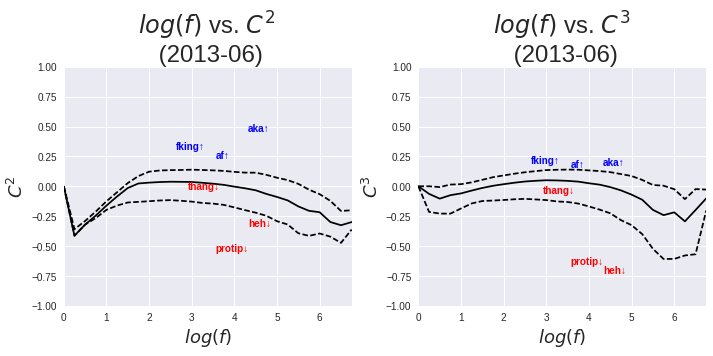

In [93]:
annotate_growth_words = ['fking', 'aka', 'af']
annotate_decline_words = ['thang', 'heh', 'protip']
annotate_words = annotate_growth_words + annotate_decline_words
growth_color = 'b'
decline_color = 'r'
N = len(annotate_growth_words)
annotate_types = dict(zip(annotate_words, ['growth',]*N + ['decline',]*N))
percentile_color = 'k'
median_color = 'k'
initial_date = '2013-06'
size = 5
rows = 1
cols = len(y_stat_names)
y_lower = -1.0
y_upper = 1.0
txt_offset_x = 0.
txt_offset_y = 0.
plt.figure(figsize=(cols*size, rows*size))
# x_lower = 1.75
# x_upper = 5
for i, (y_var, y_name) in enumerate(zip(y_stat_vars, y_stat_names)):
    print(y_name)
    plt.subplot(rows, cols, i+1)
    # plot percentiles first
    x_vals, lower_percentile_vals, median_vals, upper_percentile_vals = stat_vals[y_var]
    plt.plot(x_vals, lower_percentile_vals, color=percentile_color, linestyle='--')
    plt.plot(x_vals, upper_percentile_vals, color=percentile_color, linestyle='--')
    # plot medians differently
    plt.plot(x_vals, median_vals, color=median_color, linestyle='-')
    plt.title('%s vs. %s \n (%s)'%(x_stat_name, y_name, initial_date), fontsize=24)
    plt.xlabel(x_stat_name, fontsize=18)
    plt.ylabel(y_name, fontsize=18)
    x_lower = min(x_vals)
    x_upper = max(x_vals)
    plt.xlim(x_lower, x_upper)
    plt.ylim(y_lower, y_upper)
    for w in annotate_words:
        annotate_type = annotate_types[w]
        if(annotate_type == 'growth'):
            color = growth_color
            w_label = w + u'↑'
        elif(annotate_type == 'decline'):
            color = decline_color
            w_label = w + u'↓'
        # plot word at initial point
        combined_initial = combined_df[(combined_df['word'] == w) & (combined_df['date'] == initial_date)]
        xy_initial = (combined_initial[x_stat_var], combined_initial[y_var])
        plt.annotate(w_label, xy=xy_initial, xycoords='data', xytext=xy_initial, textcoords='data', weight='bold', color=color)
plt.tight_layout()
plt.show()

## Dynamic plot
Now plot growth words and their trajectory between $t_{i}$ and $t_{i+1}$.

$C^{2}$
$C^{3}$


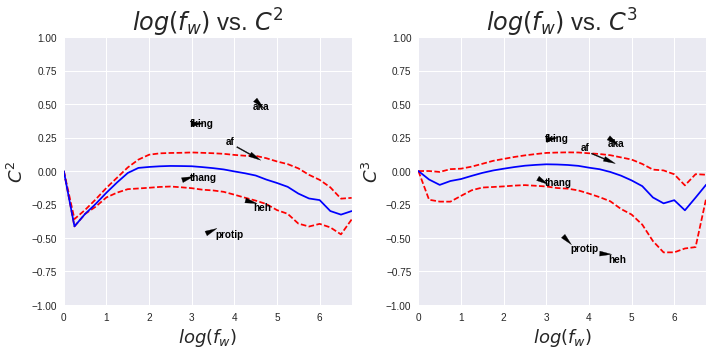

In [94]:
y_stat_names = ['$C^{2}$', '$C^{3}$']
x_stat_name = '$log(f_{w})$'
initial_date = '2014-06'
final_date = '2016-05'
size = 5
rows = 1
cols = len(y_stat_names)
y_lower = -1.0
y_upper = 1.0
txt_offset_x = 0.
txt_offset_y = 0.
plt.figure(figsize=(cols*size, rows*size))
for i, (y_var, y_name) in enumerate(zip(y_stat_vars, y_stat_names)):
    print(y_name)
    plt.subplot(rows, cols, i+1)
    # plot percentiles first
    x_vals, lower_percentile_vals, median_vals, upper_percentile_vals = stat_vals[y_var]
    plt.plot(x_vals, lower_percentile_vals, 'r--')
    plt.plot(x_vals, upper_percentile_vals, 'r--')
    # plot medians differently
    plt.plot(x_vals, median_vals, 'b-')
    plt.title('%s vs. %s'%(x_stat_name, y_name), fontsize=24)
    plt.xlabel(x_stat_name, fontsize=18)
    plt.ylabel(y_name, fontsize=18)
    x_lower = min(x_vals)
    x_upper = max(x_vals)
    plt.xlim(x_lower, x_upper)
    plt.ylim(y_lower, y_upper)
    for w in annotate_words:
        # plot word at initial point
        combined_initial = combined_df[(combined_df['word'] == w) & (combined_df['date'] == initial_date)]
        xy_initial = (combined_initial[x_stat_var], combined_initial[y_var])
#         plt.annotate(w, xy=xy_initial, xycoords='data', xytext=xy_initial, textcoords='data', weight='bold', color='k')
        # plot arrow toward final point
        combined_final = combined_df[(combined_df['word'] == w) & (combined_df['date'] == final_date)]
        xy_final = (combined_final[x_stat_var], combined_final[y_var])
        plt.annotate(w, xy_final, xycoords='data', xytext=xy_initial, textcoords='data', weight='bold', color='k',
                     arrowprops=dict(facecolor='black', width=1., headwidth=5.))
plt.tight_layout()
plt.show()

## Visualize context diversity over time
Paired with frequency so we can see whether growth words get more diverse over time.

In [3]:
tf_norm = pd.read_csv('../../data/frequency/2013_2016_tf_norm.tsv', sep='\t', index_col=0)
tf_norm.fillna(0, inplace=True)
tf_norm = tf_norm.loc[vocab]
tf_norm = pd.np.log10(smooth_stats(tf_norm))

In [4]:
print(C2.shape)

(197790, 35)


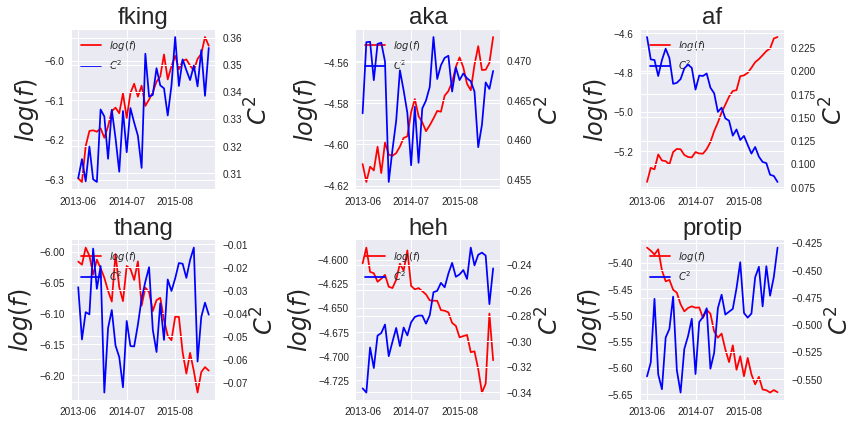

In [24]:
import data_processing
reload(data_processing)
reload(data_processing.vis_helper)
from data_processing.vis_helper import plot_separate_stats
from math import ceil
annotate_growth_words = ['fking', 'aka', 'af']
annotate_decline_words = ['thang', 'heh', 'protip']
annotate_words = annotate_growth_words + annotate_decline_words
stat1 = tf_norm.copy()
stat2 = C2.copy()
stat1 = stat1[stat2.columns]
stat1_name = '$log(f)$'
stat2_name = '$C^{2}$'
xtick_ctr = 3
cols = 3
rows = int(ceil(len(annotate_words) / cols))
width = 4
height = 3
f, axs = plt.subplots(rows, cols, figsize=(width * cols, height * rows))
for i, w in enumerate(annotate_words):
    stat1_w = stat1.loc[w]
    stat2_w = stat2.loc[w]
    j = int(i / cols)
    k = i % cols
    ax = axs[j, k]
    plot_separate_stats(w, stat1_w, stat2_w, stat1_name, stat2_name, ax=ax, xtick_ctr=xtick_ctr)
plt.tight_layout()
plt.show()

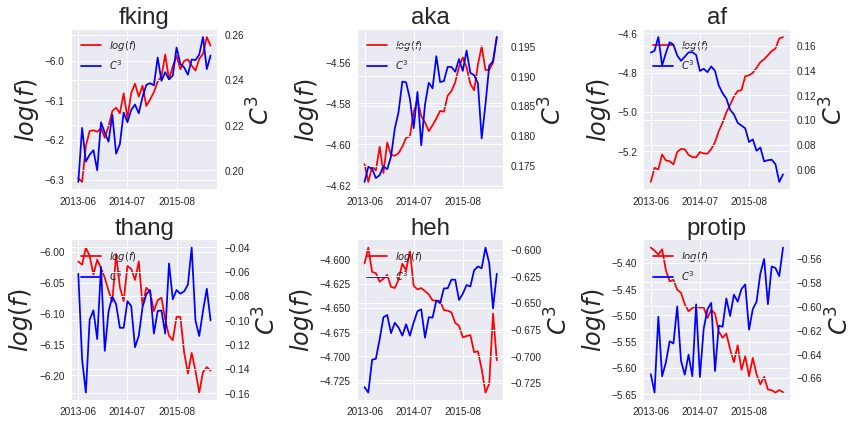

In [25]:
stat1 = tf_norm.copy()
stat2 = C3.copy()
stat1 = stat1[stat2.columns]
stat1_name = '$log(f)$'
stat2_name = '$C^{3}$'
xtick_ctr = 3
cols = 3
rows = int(ceil(len(annotate_words) / cols))
width = 4
height = 3
f, axs = plt.subplots(rows, cols, figsize=(width * cols, height * rows))
for i, w in enumerate(annotate_words):
    stat1_w = stat1.loc[w]
    stat2_w = stat2.loc[w]
    j = int(i / cols)
    k = i % cols
    ax = axs[j, k]
    plot_separate_stats(w, stat1_w, stat2_w, stat1_name, stat2_name, ax=ax, xtick_ctr=xtick_ctr)
plt.tight_layout()
plt.show()

How is it possible that growth and decline word sboth have decreasing $DF_{3}$? We need correlations to pick this apart.

In [86]:
from scipy.stats import pearsonr
growth_correls = pd.concat([pd.Series(pearsonr(stat1.loc[g], stat2.loc[g]), index=['correl', 'pvalue']) 
                            for g in growth_words], axis=1).transpose()
growth_correls.index = growth_words
decline_correls = pd.concat([pd.Series(pearsonr(stat1.loc[d], stat2.loc[d]), index=['correl', 'pvalue']) 
                             for d in decline_words], axis=1).transpose()
decline_correls.index = decline_words

In [85]:
print(growth_correls.head())

     correl        pvalue
0 -0.343112  4.360404e-02
1 -0.078529  6.538625e-01
2 -0.812922  2.984040e-09
3 -0.538200  8.533194e-04
4 -0.877546  4.552950e-12


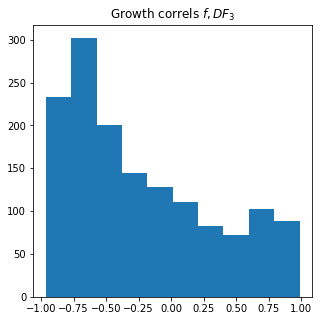

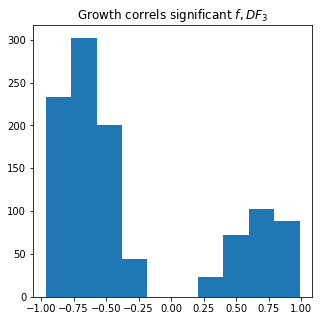

all correl -0.300 +/- 0.615
negative correl -0.658 +/- 0.162
positive correl 0.678 +/- 0.181


In [102]:
sig_correls = growth_correls[(growth_correls['pvalue'] < 0.05)]['correl']
plt.figure(figsize=(5,5))
plt.hist(growth_correls['correl'], bins=10)
plt.title('Growth correls $f, DF_{3}$')
plt.show()
plt.figure(figsize=(5,5))
plt.hist(sig_correls, bins=10)
plt.title('Growth correls significant $f, DF_{3}$')
plt.show()
neg_correls = sig_correls[sig_correls < 0.]
pos_correls = sig_correls[sig_correls > 0.]
print('all correl %.3f +/- %.3f'%(sig_correls.mean(), sig_correls.std()))
print('negative correl %.3f +/- %.3f'%(neg_correls.mean(), neg_correls.std()))
print('positive correl %.3f +/- %.3f'%(pos_correls.mean(), pos_correls.std()))

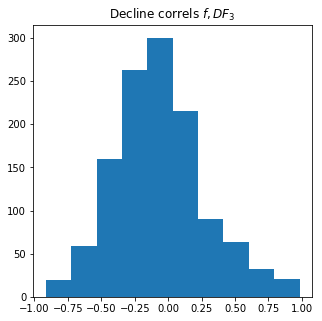

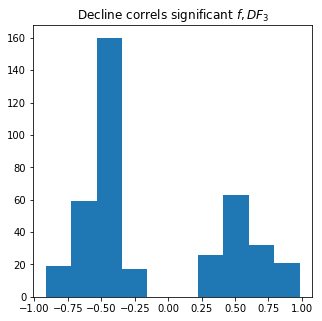

all correl -0.109 +/- 0.532
negative correl -0.491 +/- 0.128
positive correl 0.577 +/- 0.165


In [104]:
sig_correls = decline_correls[(decline_correls['pvalue'] < 0.05)]['correl']
plt.figure(figsize=(5,5))
plt.hist(decline_correls['correl'], bins=10)
plt.title('Decline correls $f, DF_{3}$')
plt.show()
plt.figure(figsize=(5,5))
plt.hist(sig_correls, bins=10)
plt.title('Decline correls significant $f, DF_{3}$')
plt.show()
neg_correls = sig_correls[sig_correls < 0.]
pos_correls = sig_correls[sig_correls > 0.]
print('all correl %.3f +/- %.3f'%(sig_correls.mean(), sig_correls.std()))
print('negative correl %.3f +/- %.3f'%(neg_correls.mean(), neg_correls.std()))
print('positive correl %.3f +/- %.3f'%(pos_correls.mean(), pos_correls.std()))

- Growth words tend to have decreasing $DF_{3}$ (mean negative correl).
- Decline words tend to have increasing $DF_{3}$ (mean negative correl). 

- Negative growth correls are slightly more negative than positive decline correls are positive. (decreasing $DF_{3}$)
- Positive growth correls are slightly more positive than negative decline correls are negative. (increasing $DF_{3}$)

So it seems like as words grow or decline, their frequency tends to outpace their distributional flexibility. Does this mean that the number of contexts tends to stay static?

## Context counts
Sanity check: how do raw context counts correlate with frequency?

In [108]:
DF2_counts = pd.read_csv('../../data/frequency/2013_2016_unique_3gram_1pos_counts.tsv', sep='\t', index_col=0)
DF3_counts = pd.read_csv('../../data/frequency/2013_2016_unique_2gram_counts.tsv', sep='\t', index_col=0)
DF2_counts.fillna(0, inplace=True)
DF3_counts.fillna(0, inplace=True)
DF2_counts = pd.np.log10(smooth_stats(DF2_counts))
DF3_counts = pd.np.log10(smooth_stats(DF3_counts))

In [109]:
tf_df_counts = melt_frames([tf_smooth, DF2_counts, DF3_counts], ['f', 'DF2', 'DF3'])

In [ ]:
import seaborn as sns
plt.figure(figsize=(5,5))
sns.regplot('f', 'DF2', data=tf_df_counts)
plt.show()
plt.figure(figsize=(5,5))
sns.regplot('f', 'DF3', data=tf_df_counts)
plt.show()

## Frequency bands
In which we explore high and low $C2$ and $C3$ values within all frequency bands [0.1,0.9].

In [37]:
from data_processing.data_handler import get_default_vocab, smooth_stats
tf = pd.read_csv('../../data/frequency/2013_2016_tf.tsv', sep='\t', index_col=0)
vocab = get_default_vocab()
tf_smooth = pd.np.log10(smooth_stats(tf.loc[vocab].fillna(0, inplace=False)))
stat_names = ['f', 'f_norm', 'C2', 'C3']
all_stats = [tf_smooth, tf_norm, C2, C3]
combined_df = melt_frames(all_stats, stat_names)
print(combined_df.head())

   word     date         f    f_norm        C2        C3
0  just  2013-06  6.660875 -2.267228 -0.210227 -0.085150
1  like  2013-06  6.632425 -2.295678 -0.073853 -0.030097
2   can  2013-06  6.518180 -2.409923 -0.262952 -0.184957
3   one  2013-06  6.484024 -2.444079 -0.217950 -0.124477
4   get  2013-06  6.457017 -2.471086 -0.263403 -0.240006


In [67]:
stat_means = combined_df.groupby('word').apply(lambda x: x.mean(axis=0))
print(stat_means.head())

              f    f_norm        C2        C3
word                                         
a      7.516469 -1.580972  0.780440  0.123068
aa     4.393091 -4.704355 -0.059172 -0.146618
aaa    4.070610 -5.026843 -0.012976 -0.074069
aaaa   2.152806 -6.945567  0.127486  0.215501
aaaah  2.874853 -6.222754  0.321923  0.448844


In [140]:
from itertools import izip
band_interval = 25
band_min = 0
band_max = 100
band_count = (band_max - band_min) / band_interval
bands = pd.np.linspace(band_min, band_max, band_count + 1)
bands = zip(bands, bands + band_interval)[:-1]
print(bands)
C_list = [C2, C3]
C_names = ['C2', 'C3']
filter_stat_name = 'f_norm'
filter_stat = stat_means[filter_stat_name]
for C, C_name in izip(C_list, C_names):
    for lower_pct, upper_pct in bands:
        lower = pd.np.percentile(filter_stat, lower_pct)
        upper = pd.np.percentile(filter_stat, upper_pct)
        relevant_stats = stat_means[(filter_stat >= lower) & (filter_stat < upper)]
        print('[%d%%, %d%%) [%.3f, %.3f)'%(lower_pct, upper_pct, lower, upper))
        print(relevant_stats[[C_name, filter_stat_name]].sort_values(C_name, inplace=False, ascending=False))

[(0.0, 25.0), (25.0, 50.0), (50.0, 75.0), (75.0, 100.0)]
[0%, 25%) [-8.894, -7.038)
                          C2    f_norm
word                                  
xlup                1.088827 -7.264581
iateacrayon         1.038892 -7.072359
preparin            0.972075 -7.310896
hiddenpower         0.870065 -7.322880
foker               0.839766 -7.309470
gavriel             0.781465 -7.038369
majutsu             0.777181 -7.190674
shoprbc             0.763488 -7.299500
directron           0.756683 -7.161691
sickleflow          0.722180 -7.094894
roomful             0.704476 -7.154668
lanaaa              0.692377 -7.119742
tavataan            0.678643 -7.113539
deaddove            0.675178 -7.470956
thisthis            0.674853 -7.360908
nioj                0.671467 -7.261041
mkf                 0.664737 -7.408122
pesar               0.655124 -7.139876
pluribus            0.654502 -7.053973
plupart             0.649854 -7.058721
ijk                 0.641830 -7.261129
erektile           

Same thing but with uneven frequency bands to account for skewed distribution.

In [80]:
from itertools import izip
bands = [0., 30., 50., 75., 80., 85., 90., 95.]
bands = zip(bands[:-1], bands[1:])
print(bands)
C_list = [C2, C3]
C_names = ['C2', 'C3']
filter_stat_name = 'f_norm'
filter_stat = stat_means[filter_stat_name]
for C, C_name in izip(C_list, C_names):
    for lower_pct, upper_pct in bands:
        lower = pd.np.percentile(filter_stat, lower_pct)
        upper = pd.np.percentile(filter_stat, upper_pct)
        relevant_stats = stat_means[(filter_stat >= lower) & (filter_stat < upper)]
        print('[%d%%, %d%%) [%.3f, %.3f)'%(lower_pct, upper_pct, lower, upper))
        print(relevant_stats[[C_name, filter_stat_name]].sort_values(C_name, inplace=False, ascending=False))

[(0.0, 30.0), (30.0, 50.0), (50.0, 75.0), (75.0, 80.0), (80.0, 85.0), (85.0, 90.0), (90.0, 95.0)]
[0%, 30%) [-9.228, -6.978)
                     C2    f_norm
word                             
nudetorial     1.166968 -7.071987
xlup           1.088827 -7.264581
iateacrayon    1.038892 -7.134217
gemle          1.010996 -7.159070
preparin       0.972075 -7.310896
whynotboth     0.916390 -7.020076
tusinda        0.895093 -7.873500
hiddenpower    0.870065 -7.486980
pppps          0.839842 -7.188154
foker          0.839766 -7.309470
gavriel        0.781465 -7.038369
majutsu        0.777181 -7.190674
shoprbc        0.763488 -7.797814
directron      0.756683 -7.220997
krat           0.727523 -7.026519
sickleflow     0.722180 -7.094894
roomful        0.704476 -7.154668
lanaaa         0.692377 -7.119742
tavataan       0.678643 -7.113539
deaddove       0.675178 -7.470956
thisthis       0.674853 -7.360908
nioj           0.671467 -7.261041
mkf            0.664737 -7.408122
pesar          0.655124 -

Same thing but just with innovations.

In [35]:
growth_words = pd.read_csv('../../data/frequency/word_lists/2013_2016_growth_words_clean.csv', index_col=False)['word'].tolist()
print(len(growth_words))

1458


In [87]:
print(growth_stat_means.head())

                 f    f_norm        C2        C3
word                                            
ab        3.965118 -5.132340 -0.141278 -0.145289
abit      3.283629 -5.813882 -0.195361 -0.196561
abt       2.910017 -6.187600 -0.250908 -0.198472
abusable  2.641600 -6.456172 -0.052229 -0.057853
accs      2.359433 -6.738898 -0.128388 -0.103000


### Context diversity bands by frequency

In [89]:
bands = [0., 30., 50., 75., 90., 100.]
bands = zip(bands[:-1], bands[1:])
print(bands)
C_list = [C2, C3]
C_names = ['C2', 'C3']
filter_stat_name = 'f_norm'
growth_stat_means = stat_means.loc[growth_words]
filter_stat = growth_stat_means[filter_stat_name]
for C, C_name in izip(C_list, C_names):
    for lower_pct, upper_pct in bands:
        lower = pd.np.percentile(filter_stat, lower_pct)
        upper = pd.np.percentile(filter_stat, upper_pct)
        relevant_stats = growth_stat_means[(filter_stat >= lower) & (filter_stat < upper)]
        print('[%d%%, %d%%) [%.3f, %.3f)'%(lower_pct, upper_pct, lower, upper))
        print(relevant_stats[[C_name, filter_stat_name]].sort_values(C_name, inplace=False, ascending=False))

[(0.0, 30.0), (30.0, 50.0), (50.0, 75.0), (75.0, 90.0), (90.0, 100.0)]
[0%, 30%) [-7.494, -6.843)
                    C2    f_norm
word                            
preciate      0.440989 -7.038951
saaame        0.382742 -6.887867
someshit      0.335099 -6.885682
wubba         0.301218 -7.151578
tldw          0.295917 -6.988370
dooope        0.288349 -7.190642
lolk          0.265993 -7.233472
gtfoh         0.262687 -7.170511
trueee        0.211141 -7.144378
btag          0.207580 -6.915548
byeee         0.205675 -7.044565
replug        0.198918 -7.079886
thirding      0.178697 -6.980765
eventers      0.164756 -7.010446
gottem        0.152301 -7.108059
ijs           0.150929 -7.284630
evented       0.150897 -7.011173
relisten      0.144634 -7.075173
desolder      0.141842 -6.936324
earthers      0.139493 -6.975702
ayyye         0.134153 -7.154776
pushdowns     0.126090 -7.182037
screee        0.124751 -7.253357
smfh          0.123539 -6.865342
idfk          0.122214 -6.927129
kys        

## Context diversity by part of speech

In [8]:
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
C2 = pd.read_csv('../../data/frequency/2013_2016_2gram_residuals.tsv', sep='\t', index_col=0)
C3 = pd.read_csv('../../data/frequency/2013_2016_3gram_residuals.tsv', sep='\t', index_col=0)

In [4]:
tags = pd.read_csv('../../data/frequency/2013_2016_tag_pcts.tsv', sep='\t', index_col=0)
tag_estimates = tags.apply(lambda x: x.argmax(), axis=1)
tag_list = sorted(tags.columns)

In [40]:
print(tag_estimates.value_counts())

N    42906
^    27715
V    14819
A     8352
R     2271
G     1718
!     1379
P      238
O      199
L      147
D      110
$       39
&       32
E       19
Z       17
,       13
S       10
T        9
~        3
U        2
X        1
Y        1
dtype: int64


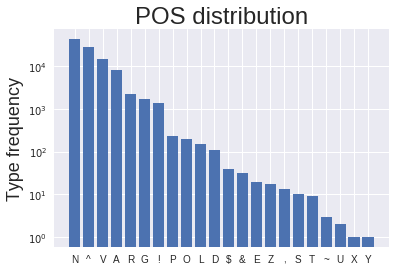

In [41]:
# get tag counts
tag_counts = tag_estimates.value_counts()
tag_names = tag_counts.index.tolist()
X = pd.np.arange(len(tag_counts))
plt.bar(X, tag_counts.values)
plt.xticks(X, tag_names)
plt.yscale('log')
plt.title('POS distribution', fontsize=24)
plt.ylabel('Type frequency', fontsize=18)
plt.show()

Most words are either nouns or proper nouns. Surprise!

Now make a boxplot for $C2$ and $C3$ over all parts of speech.

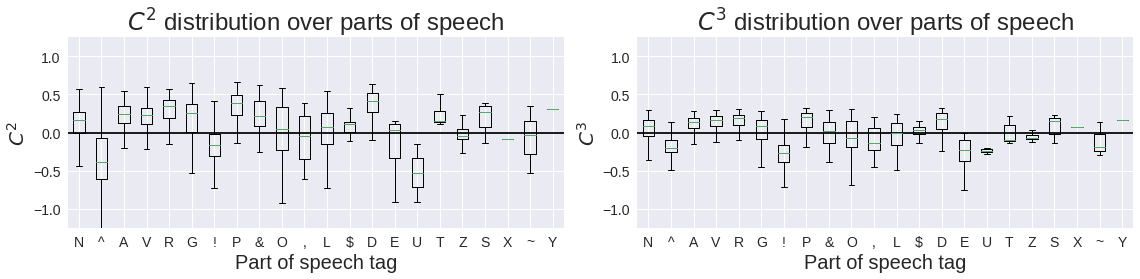

In [13]:
tag_estimates_df = pd.DataFrame(tag_estimates, columns=['POS'])
C_list = [C2, C3]
C_names = ['$C^{2}$', '$C^{3}$']
xlabels = tag_estimates_df['POS'].unique()
L = len(xlabels)
X = pd.np.arange(L) + 1
ylim = [-1.25, 1.25]
i = 1
width = 8
height = 4
plt.figure(figsize=(width * len(C_names), height))
for C, C_name in zip(C_list, C_names):
    plt.subplot(1, 2, i)
    C_pos = tag_estimates_df.groupby('POS').apply(lambda x: C.loc[x.index].mean(axis=1)).dropna(inplace=False)
    box_data = [C_pos.loc[x].values for x in xlabels]
    plt.boxplot(box_data, showfliers=True)
    plt.xticks(X, xlabels, size=14)
    plt.yticks(size=14)
    plt.xlabel('Part of speech tag', fontsize=20)
    plt.ylabel(C_name, fontsize=20)
    plt.title('%s distribution over parts of speech'%(C_name), fontsize=24)
    plt.ylim(ylim)
    # draw the x axis
    plt.plot([0, L+1], [0,0], 'k')
    i += 1
plt.tight_layout()
plt.show()

Most POS tags have $C2$ and $C3$ close to zero.

Notable exceptions:

- adverb (`R`) positive
- exclamation (`!`) negative
- pre/post position (`P`) positive
- determiners (`D`) positive
- verb particle (`T`) negative ($C3$)
- proper noun + possessive (`Z`) positive
- nominal + possessive (`S`) positive
- discourse marker (`~`) negative

Plot the same thing but with all labels written out.

In [33]:
pos_names = pd.read_csv('../../data/metadata/tag_meaning.tsv', sep='\t', index_col=None)
print(pos_names)

   tag                                            meaning
0    N                                        common noun
1    ^                                        proper noun
2    V                                               verb
3    A                                          adjective
4    R                                             adverb
5    G  abbreviation/foreign word/possessive ending/sy...
6    !                                       interjection
7    P                           preposition/postposition
8    O                                            pronoun
9    L                      nominal+verbal/verbal+nominal
10   D                                         determiner
11   $                                            numeral
12   &                                        conjunction
13   E                                           emoticon
14   Z                             proper noun+possessive
15   ,                                        punctuation
16   S        

In [48]:
C2 = pd.read_csv('../../data/frequency/2013_2016_2gram_residuals.tsv', sep='\t', index_col=0)
C3 = pd.read_csv('../../data/frequency/2013_2016_3gram_residuals.tsv', sep='\t', index_col=0)

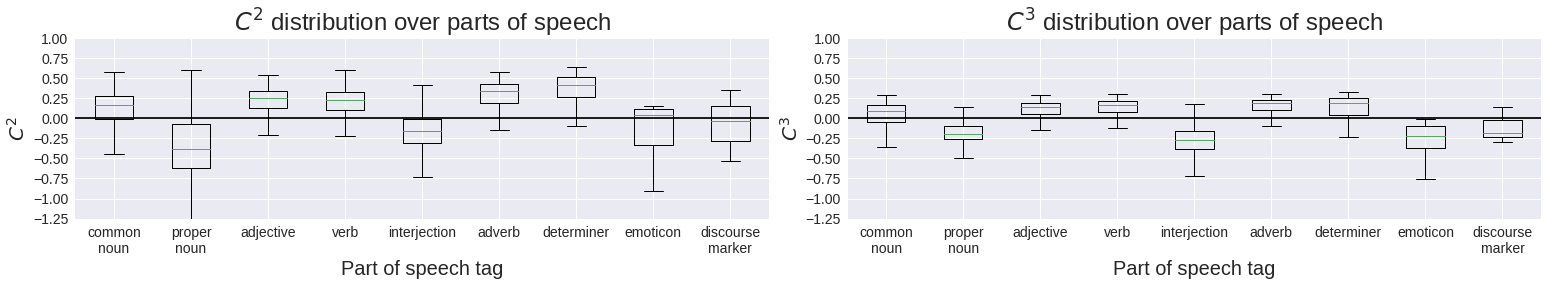

In [51]:
valid_pos_tags = ['N', '^', 'A', 'V', '!', 'R', 'D', 'E', '~']
C_list = [C2, C3]
C_names = ['$C^{2}$', '$C^{3}$']
xlabels = [pos_names[pos_names['tag'] == t]['meaning'].values[0].replace(' ', '\n') for t in valid_pos_tags]
L = len(xlabels)
X = pd.np.arange(L) + 1
ylim = [-1.25, 1.]
i = 1
width = 1.2*len(xlabels)
height = 4
plt.figure(figsize=(width * len(C_names), height))
for C, C_name in zip(C_list, C_names):
    plt.subplot(1, 2, i)
    C_pos = tag_estimates_df.groupby('POS').apply(lambda x: C.loc[x.index].mean(axis=1)).dropna(inplace=False)
    box_data = [C_pos.loc[x].values for x in valid_pos_tags]
    plt.boxplot(box_data, showfliers=True)
    plt.xticks(X, xlabels, size=14)
    plt.yticks(size=14)
    plt.xlabel('Part of speech tag', fontsize=20)
    plt.ylabel(C_name, fontsize=20)
    plt.title('%s distribution over parts of speech'%(C_name), fontsize=24)
    plt.ylim(ylim)
    # draw the x axis
    plt.plot([0, L+1], [0,0], 'k')
    i += 1
plt.tight_layout()
plt.show()

## Visualize context diversity by word type
We can group the lexical innovations by word type (acronym, abbreve, etc.) and then compute the CD in the same split. There might be confounds with POS tags (e.g. abbreves tend to be nouns), so we might have to subdivide the groups.

Note: these only include the growth words. We'll need to expand to the decline and growth-decline words eventually!!

In [26]:
word_categories = pd.read_csv('../../data/frequency/word_lists/2013_2016_word_categories.csv', index_col=False)
print(word_categories['category'].value_counts())

K    386
D    378
R    238
C    195
S     99
A     83
O     37
Name: category, dtype: int64


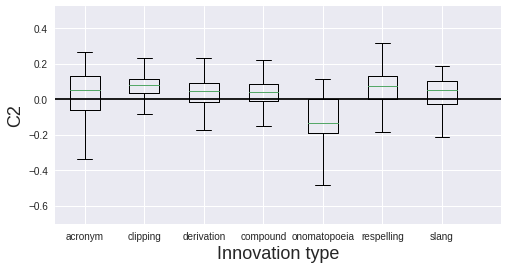

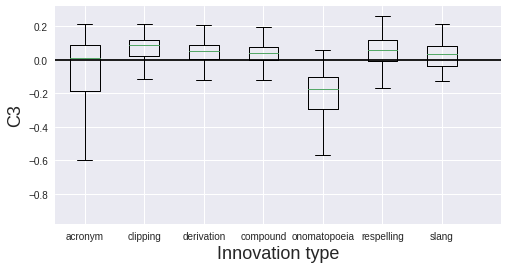

In [29]:
C_list = [C2, C3]
C_names = ['C2', 'C3']
category_name_lookup = {'A' : 'acronym', 'K' : 'compound', 'C' : 'clipping', 'D' : 'derivation', 
                  'R' : 'respelling', 'O' : 'onomatopoeia', 'S' : 'slang'}
xlabels = sorted(word_categories['category'].unique().tolist())
xlabels_full = [category_name_lookup[x] for x in xlabels]
L = len(xlabels) + 1
X = pd.np.arange(L) + 1
width = 1.
height = 4
for C, C_name in zip(C_list, C_names):
    C_pos = word_categories.groupby('category').apply(lambda x: C.loc[x['word']].mean(axis=1)).dropna(inplace=False)
    box_data = [C_pos.loc[x].values for x in xlabels]
    plt.figure(figsize=(width * L, height))
    plt.boxplot(box_data)
    plt.xticks(X, xlabels_full)
    plt.xlabel('Innovation type', fontsize=18)
    plt.ylabel(C_name, fontsize=18)
    # draw the x axis
    plt.plot([0, L], [0,0], 'k')
    plt.show()

High context diversity:

- `O` onomatopoeia

We see onomatopoeia like `yas` and `haha` used in a surprisingly large range of contexts.

Expected context diversity:

- `A` acronyms

Most acronyms like `af` are more frequent than the other innovations 

## Visualize context diversity distribution
Use a joint plot to visualize the frequency/context diversity distribution.

In [16]:
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import sys
if('..' not in sys.path):
    sys.path.append('..')
import data_processing
reload(data_processing)
import data_processing.vis_helper
reload(data_processing.vis_helper)
from data_processing.vis_helper import plot_jointplot
from data_processing.data_handler import melt_frames, smooth_stats

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [17]:
tf_norm = pd.read_csv('../../data/frequency/2013_2016_tf_norm.tsv', sep='\t', index_col=0)
C2 = pd.read_csv('../../data/frequency/2013_2016_2gram_1pos_residuals.tsv', sep='\t', index_col=0)
C3 = pd.read_csv('../../data/frequency/2013_2016_3gram_1pos_residuals.tsv', sep='\t', index_col=0)
tf_norm = pd.np.log10(smooth_stats(tf_norm))

In [18]:
all_stats = [tf_norm, C2, C3]
vocab = reduce(lambda x,y: x&y, [s.index for s in all_stats])
all_stats = [s.loc[vocab] for s in all_stats]
stat_names = ['f', 'C2', 'C3']
combined_stats = melt_frames(all_stats, stat_names)
print(combined_stats.head())

      word     date         f        C2        C3
0       aa  2013-06 -4.759620  0.123702  0.148911
1      aaa  2013-06 -4.966801  0.041110  0.062186
2     aaaa  2013-06 -6.909026 -0.138646 -0.196020
3    aaaah  2013-06 -6.182645 -0.393687 -0.497060
4  aaaahhh  2013-06 -6.598724 -0.462309 -0.471153


In [19]:
mean_stats = combined_stats.groupby('word').apply(pd.np.mean)
print(mean_stats.head())

                f        C2        C3
word                                 
aa      -4.703634  0.112521  0.155242
aaa     -5.026397  0.051318  0.078956
aaaa    -6.948163 -0.168376 -0.217695
aaaah   -6.222556 -0.337888 -0.456020
aaaahhh -6.685749 -0.335813 -0.414644


In [20]:
# annotate_words = ['someshit', 'fckin', 'shittalking', 'smdh', 'lowkey', 'funsies', 
#                   'esque', 'pmed', 'rn', 'idk', 'boi']
annotate_words = ['af', 'megathreads', 'bc', 'jobber',
                  'tbh', 'otp', 'fav', 
                  'autists', 'clunky', 'neato', 
                  'pilled', 'aka',
                 ]

In [ ]:
print(mean_stats.loc[annotate_words])

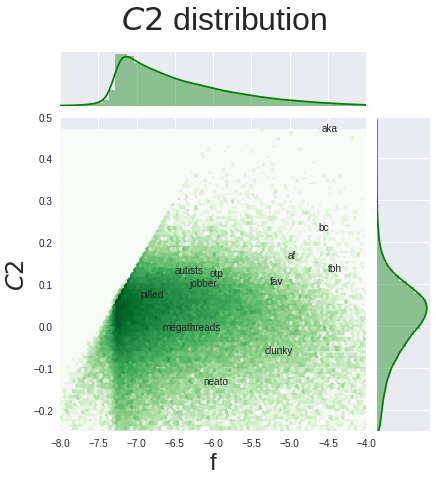

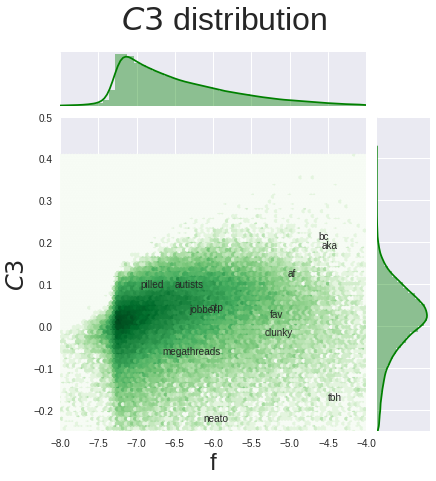

In [21]:
x_stat_name = 'f'
C_names = ['C2', 'C3']
xlim = [-8, -4]
ylim = [-0.25, 0.5]
for C_name in C_names:
    relevant_stats = mean_stats[(mean_stats[x_stat_name] >= xlim[0]) & (mean_stats[x_stat_name] <= xlim[1]) &
                                (mean_stats[C_name] >= ylim[0]) & (mean_stats[C_name] <= ylim[1])]
    plot_jointplot(relevant_stats, x_stat_name, C_name, xlim=xlim, ylim=ylim, annotate_words=annotate_words)
    plt.show()

## Sanity check: re-compute residuals
Are we sure that the residuals are doing what they're supposed to?

In [10]:
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import sys
if('..' not in sys.path):
    sys.path.append('..')
from data_processing.data_handler import smooth_stats, melt_frames

In [12]:
tf = pd.read_csv('../../data/frequency/2013_2016_tf.tsv', sep='\t', index_col=0)

In [13]:
unique_counts_2 = pd.read_csv('../../data/frequency/2013_2016_unique_2gram_1pos_counts.tsv', sep='\t', index_col=0)
unique_counts_3 = pd.read_csv('../../data/frequency/2013_2016_unique_3gram_1pos_counts.tsv', sep='\t', index_col=0)

In [14]:
vocab = list(tf.index & unique_counts_2.index & unique_counts_3.index)
print(len(vocab))
print(tf.shape)
print(unique_counts_2.shape)
print(unique_counts_3.shape)

100120
(19150215, 36)
(100170, 36)
(100182, 36)


In [15]:
all_stats = [tf, unique_counts_2, unique_counts_3]
all_stats = [smooth_stats(s.loc[vocab].fillna(0, inplace=False)) for s in all_stats]
stat_names = ['f', 'unique_2', 'unique_3']
combined_count_tf = melt_frames(all_stats, stat_names)
print(combined_count_tf.head())

    word     date           f  unique_2   unique_3
0      a  2013-06  22617018.0  141933.0  2304572.0
1     aa  2013-06     14740.0    3221.0     6755.0
2    aaa  2013-06      9148.0    1916.0     3675.0
3   aaaa  2013-06       105.0      58.0       44.0
4  aaaah  2013-06       557.0     102.0       92.0


In [16]:
# log EVERYTHING
combined_count_tf[stat_names] = combined_count_tf[stat_names].apply(pd.np.log10, axis=0)

In [17]:
from scipy.stats import linregress
f_name = 'f'
unique_count_names = ['unique_2', 'unique_3']
for unique_count_name in unique_count_names:
    m, b, r, p, err = linregress(combined_count_tf[f_name], combined_count_tf[unique_count_name])
    print('%s = %.3f*%s + %.3f (R=%.3f, p=%.3E)'%(unique_count_name, m, f_name, b, r, p))

unique_2 = 0.699*f + 0.481 (R=0.977, p=0.000E+00)
unique_3 = 0.860*f + 0.099 (R=0.985, p=0.000E+00)


In [24]:
resid_df = combined_count_tf.copy()
x = resid_df[f_name]
for unique_count_name in unique_count_names:
    y = resid_df[unique_count_name]
    m, b, r, p, err = linregress(x, y)
    y_expected = m*x + b
    resid_name = 'C_%d'%(int(unique_count_name.split('_')[1]))
    resid_df['%s_expected'%(resid_name)] = y_expected
    resids = y - y_expected
    resid_df[resid_name] = resids

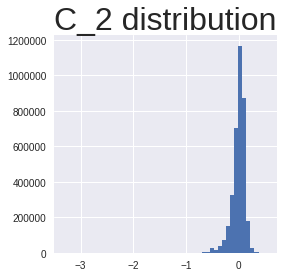

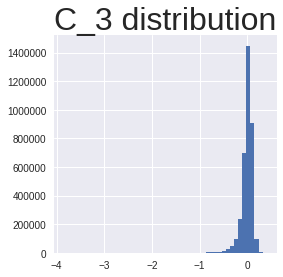

In [25]:
resid_names = ['C_2', 'C_3']
bins = 50
for resid_name in resid_names:
    plt.figure(figsize=(4,4))
    plt.hist(resid_df[resid_name], bins=bins)
    plt.title('%s distribution'%(resid_name), fontsize=32)
    plt.show()

In [28]:
expected_names = ['%s_expected'%(n) for n in resid_names]
resid_mean = resid_df[['word'] + unique_count_names + resid_names + expected_names].groupby('word').apply(pd.np.mean)
print(resid_mean.head())

       unique_2  unique_3       C_2       C_3  C_2_expected  C_3_expected
word                                                                     
a      5.115047  6.472778 -0.620751 -0.091442      5.735798      6.564220
aa     3.653517  4.030622  0.100189  0.151610      3.553329      3.879012
aaa    3.369527  3.677585  0.041780  0.076117      3.327747      3.601467
aaaa   1.823932  1.733866 -0.161286 -0.215816      1.985218      1.949682
aaaah  2.154758  2.117074 -0.337073 -0.455921      2.491831      2.572995


In [29]:
for resid_name in resid_names:
    print(resid_name)
    print(resid_mean.sort_values(resid_name, inplace=False, ascending=False))

C_2
               unique_2  unique_3       C_2       C_3  C_2_expected  \
word                                                                  
versus         4.064748  4.224325  0.516535  0.351608      3.548212   
ala            3.459071  3.417505  0.508833  0.280507      2.950238   
motherfucking  3.546393  3.587806  0.456587  0.279090      3.089806   
aka            4.089410  4.162748  0.452882  0.181372      3.636528   
alongside      3.799023  3.939640  0.452118  0.314603      3.346904   
ftw            3.694501  3.463867  0.441575 -0.045543      3.252925   
ans            3.208571  3.116478  0.428830  0.189252      2.779741   
via            4.352800  4.738035  0.427741  0.401664      3.925058   
themed         3.623290  3.782791  0.420598  0.335186      3.202692   
abd            3.036796  2.961469  0.420331  0.235129      2.616466   
thr            3.180701  3.202033  0.411792  0.288134      2.768909   
involving      3.846226  4.083346  0.410680  0.349248      3.435546   
th

In [30]:
# test words with expected high values and expected low values
test_words = ['aka', 'dis', 'af', 'motherfucking', 'tbh', 'lot', 'able']
print(resid_mean.loc[test_words])

               unique_2  unique_3       C_2       C_3  C_2_expected  \
word                                                                  
aka            4.089410  4.162748  0.452882  0.181372      3.636528   
dis            3.333425  3.484547  0.147827  0.057974      3.185598   
af             3.480880  3.717260  0.153184  0.115856      3.327696   
motherfucking  3.546393  3.587806  0.456587  0.279090      3.089806   
tbh            3.809714  3.869187  0.117108 -0.181185      3.692606   
lot            3.835165  4.071799 -0.943913 -1.315317      4.779077   
able           3.624419  3.778747 -0.897197 -1.291600      4.521616   

               C_3_expected  
word                         
aka                3.981377  
dis                3.426573  
af                 3.601404  
motherfucking      3.308716  
tbh                4.050372  
lot                5.387115  
able               5.070347  
